In [122]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
import uuid
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from datetime import datetime

In [3]:
measurement_meds_test = pd.read_csv('testing_data/measurement_meds_test.csv')
measurement_observation_test =  pd.read_csv('testing_data/measurement_observation_test.csv')
observation_test = pd.read_csv('testing_data/observation_test.csv')
person_demographics_episode_test = pd.read_csv('testing_data/person_demographics_episode_test.csv')
proceduresoccurrences_test = pd.read_csv('testing_data/proceduresoccurrences_test.csv')
sepsis_label_test = pd.read_csv('testing_data/SepsisLabel_test.csv')
devices_test = pd.read_csv('testing_data/devices_test.csv')
drugsexposure_test = pd.read_csv('testing_data/drugsexposure_test.csv')
measurement_lab_test = pd.read_csv('testing_data/measurement_lab_test.csv')

In [2]:
measurement_meds_train = pd.read_csv('training_data/measurement_meds_train.csv').drop_duplicates()
measurement_observation_train =  pd.read_csv('training_data/measurement_observation_train.csv').drop_duplicates()
observation_train = pd.read_csv('training_data/observation_train.csv').drop_duplicates()
person_demographics_episode_train = pd.read_csv('training_data/person_demographics_episode_train.csv').drop_duplicates()
proceduresoccurrences_train = pd.read_csv('training_data/proceduresoccurrences_train.csv').drop_duplicates()
sepsis_label_train = pd.read_csv('training_data/SepsisLabel_train.csv').drop_duplicates()
devices_train = pd.read_csv('training_data/devices_train.csv').drop_duplicates()
drugsexposure_train = pd.read_csv('training_data/drugsexposure_train.csv').drop_duplicates()
measurement_lab_train = pd.read_csv('training_data/measurement_lab_train.csv').drop_duplicates()

train_dfs = [measurement_meds_train, measurement_observation_train, observation_train, proceduresoccurrences_train, sepsis_label_train, devices_train, drugsexposure_train, measurement_lab_train]

In [3]:
# Making uid by person id and datetime of interaction

def uid_maker(df_list: list):
    for j, df in enumerate(df_list):
        # print(df.columns)
        datetime_index = np.argmax([i.find('datetime') for i in df.columns])
        date_column = df.columns[datetime_index]
        personid_index = np.argmax([i.find('person_id') for i in df.columns])
        personid_column = df.columns[personid_index]
        # print(f'date col: {date_column} personid: {personid_column}')
        df['uid'] = df[date_column].astype(str) + df[personid_column].astype(str)
        if j != 4:
            df.drop(columns=[date_column,personid_column],inplace=True)

uid_maker(train_dfs)

In [ ]:
#Combining rows of drug exposure to make one row per datetime via uid

drugsexposure_train_2 = pd.DataFrame(columns = ['uid', 'drugs', 'routes', 'visit_occurrence_id'])
for x in tqdm(np.unique(drugsexposure_train['uid'])):
    drugs = drugsexposure_train[drugsexposure_train['uid']==x]['drug_concept_id'].to_list()
    drugs.sort()
    try:
        route = drugsexposure_train[drugsexposure_train['uid']==x]['route_concept_id'].to_list()
        route = list(set(route))
        route = [str(i) for i in route]
        route.sort()
    except:
        route = drugsexposure_train[drugsexposure_train['uid']==x]['route_concept_id'].to_list()
        route = list(set(route))
    visit_occurrence = drugsexposure_train[drugsexposure_train['uid']==x]['visit_occurrence_id'].to_list()[0]
    drugsexposure_train_2.loc[len(drugsexposure_train_2)]= [x,drugs,route, visit_occurrence]

100%|██████████| 150407/150407 [1:51:52<00:00, 22.41it/s]  


In [5]:
drugsexposure_train_2.to_csv('processed_drug_exposure_train.csv')

In [6]:
drugsexposure_train_2 = pd.read_csv('processed_drug_exposure_train.csv',index_col=0)

In [ ]:
#Dropping lab measurements that lack any values + combining rows that have values in different categories for same datetime via uid

measurement_lab_train_2 = measurement_lab_train.copy()
print(len(measurement_lab_train))
# measurement_lab_train_2.drop(columns=['visit_occurrence_id'],inplace=True)
measurement_lab_train_2 = measurement_lab_train_2.dropna(subset=measurement_lab_train_2.select_dtypes(float).columns, how='all')
measurement_lab_train_2_count = pd.DataFrame([list(i) for i in Counter(measurement_lab_train_2['uid']).items()],columns=['uid','count'])
measurement_lab_train_2_count['count'].astype(int)
measurement_lab_rows = pd.DataFrame()
measurement_lab_extras = measurement_lab_train_2_count[measurement_lab_train_2_count['count']>1]
for j in [i for i in measurement_lab_extras['uid']]:
    measurement_lab_rows = pd.concat([measurement_lab_rows,measurement_lab_train_2[measurement_lab_train_2['uid']==j].max().to_frame().T]).reset_index(drop=True)
measurement_lab_train_2.drop(index=[i for i in measurement_lab_train_2[measurement_lab_train_2['uid']==measurement_lab_extras['uid'].item()].index], axis=1,inplace=True)
measurement_lab_train_2 = pd.concat([measurement_lab_train_2,measurement_lab_rows]).reset_index(drop=True)

69307


In [8]:
person_demographics_episode_train.drop(columns='person_id',inplace=True)

In [107]:
factors = pd.merge(left=drugsexposure_train_2,right=devices_train,how='outer',on='uid')
factors = pd.merge(left=factors,right=measurement_lab_train_2,how='outer',on='uid')
factors = pd.merge(left=factors,right=person_demographics_episode_train,how='outer',on='visit_occurrence_id')
factors = pd.merge(left=sepsis_label_train,right=factors,how='inner',on='uid')

In [108]:
factors.fillna(value=np.nan,inplace=True)

In [109]:
factors_2 = factors.copy()

for person in np.unique(factors_2['person_id'])

SyntaxError: expected ':' (1061414036.py, line 3)

In [110]:
np.unique(factors_2['person_id'])

array([    510305,    1765616,    2255421, ..., 2146062017, 2146308255,
       2146982383], dtype=int64)

In [126]:
factors[factors['person_id']==2255421]

,person_id,measurement_datetime,SepsisLabel,uid,drugs,routes,visit_occurrence_id_x,visit_occurrence_id_y,device,visit_occurrence_id,Base excess in Venous blood by calculation,Base excess in Arterial blood by calculation,Phosphate [Moles/volume] in Serum or Plasma,Potassium [Moles/volume] in Blood,Bilirubin.total [Moles/volume] in Serum or Plasma,Neutrophil Ab [Units/volume] in Serum,Bicarbonate [Moles/volume] in Arterial blood,Hematocrit [Volume Fraction] of Blood,Glucose [Moles/volume] in Serum or Plasma,Calcium [Moles/volume] in Serum or Plasma,Chloride [Moles/volume] in Blood,Sodium [Moles/volume] in Serum or Plasma,C reactive protein [Mass/volume] in Serum or Plasma,Carbon dioxide [Partial pressure] in Venous blood,Oxygen [Partial pressure] in Venous blood,Albumin [Mass/volume] in Serum or Plasma,Bicarbonate [Moles/volume] in Venous blood,Oxygen [Partial pressure] in Arterial blood,Carbon dioxide [Partial pressure] in Arterial blood,Interleukin 6 [Mass/volume] in Body fluid,Magnesium [Moles/volume] in Blood,Prothrombin time (PT),Procalcitonin [Mass/volume] in Serum or Plasma,Lactate [Moles/volume] in Blood,Creatinine [Mass/volume] in Blood,Fibrinogen measurement,Bilirubin measurement,Partial thromboplastin time,activated,Total white blood count,Platelet count,White blood cell count,Blood venous pH,D-dimer level,Blood arterial pH,Hemoglobin [Moles/volume] in Blood,Ionised calcium measurement,visit_start_date,birth_datetime,age_in_months,gender
72363,2255421,2019-10-04 10:00:00,0,2019-10-04 10:00:002255421,NaN,NaN,NaN,NaN,NaN,2.041654e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-01,2010-02-17,116.0,FEMALE
180580,2255421,2019-10-04 08:00:00,0,2019-10-04 08:00:002255421,['methylprednisolone'],['Intravenous'],2.041654e+09,NaN,NaN,2.041654e+09,-4.0,NaN,NaN,3.5,NaN,15.8,NaN,NaN,NaN,NaN,109.0,138.0,NaN,42.7,76.0,NaN,21.2,NaN,NaN,NaN,NaN,NaN,NaN,3.4,56.9,NaN,NaN,NaN,NaN,NaN,0.4,7.32,NaN,NaN,NaN,1.28,NaN,2019-10-01,2010-02-17,116.0,FEMALE
199548,2255421,2019-10-04 07:00:00,0,2019-10-04 07:00:002255421,NaN,NaN,NaN,NaN,NaN,2.041654e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.1,242.0,NaN,NaN,NaN,NaN,13.6,NaN,NaN,2019-10-01,2010-02-17,116.0,FEMALE
219811,2255421,2019-11-20 18:00:00,0,2019-11-20 18:00:002255421,NaN,NaN,NaN,NaN,NaN,2.041654e+09,NaN,NaN,NaN,NaN,NaN,3.3,NaN,38.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,229.0,NaN,NaN,NaN,NaN,12.9,NaN,NaN,2019-10-01,2010-02-17,116.0,FEMALE


In [ ]:
person_demographics_episode_train[person_demographics_episode_train['']]

In [113]:
person_demographics_episode_train_2 = pd.read_csv('training_data/person_demographics_episode_train.csv').drop_duplicates()

In [ ]:
# Formatting birthdays using datetime so that age can be calculated at other steps

new_birthday_col = pd.DataFrame(columns=['formatted_bdays', 'person_id'])
for birthday in person_demographics_episode_train_2['birth_datetime']:
    birthdate_formatted = datetime.strptime(birthday,'%Y-%m-%d')
    assoc_person = person_demographics_episode_train_2[person_demographics_episode_train_2['birth_datetime']==birthday]['person_id'].to_list()[0]
    new_birthday_col.loc[len(new_birthday_col)] = [birthdate_formatted, assoc_person]

In [134]:
new_birthday_col

,formatted_bdays,person_id
0,2002-05-30,1354145347
1,2002-03-23,1211327821
2,2003-01-15,127099706
3,2003-02-21,60715713
4,2003-02-16,2088110327
...,...,...
3386,2016-07-15,1419743378
3387,2023-12-28,349598074
3388,2024-01-07,1706017786
3389,2012-12-16,653129160


In [136]:
person_demographics_episode_train_2

,visit_occurrence_id,person_id,visit_start_date,birth_datetime,age_in_months,gender
0,1933014304,1354145347,2021-12-15,2002-05-30,235,MALE
1,469091308,1211327821,2020-01-28,2002-03-23,214,MALE
2,822483951,127099706,2020-06-01,2003-01-15,209,MALE
3,862311390,60715713,2021-02-14,2003-02-21,216,MALE
4,960347036,2088110327,2020-07-24,2003-02-16,209,MALE
...,...,...,...,...,...,...
3386,702765543,1419743378,2024-11-28,2016-07-15,100,MALE
3387,957374218,349598074,2024-12-06,2023-12-28,12,FEMALE
3388,1850602236,1706017786,2024-12-08,2024-01-07,11,MALE
3389,1297625375,653129160,2024-12-17,2012-12-16,144,MALE


In [40]:
factors.drop(columns=['visit_occurrence_id','visit_occurrence_id_x','visit_occurrence_id_y','visit_start_date','measurement_datetime'],inplace=True)

In [41]:
factors.to_csv('factors.csv')

In [62]:
le = LabelEncoder()
le.fit(factors.loc[:,'drugs'])
new_drugs = le.transform(factors.loc[:,'drugs'])

In [76]:
col_list = ['drugs', 'routes', 'device', 'birth_datetime','gender']

In [75]:
le_dictionary = {}
def categorical_encoder(col_name: list):
    for name in col_name:
        le = LabelEncoder()
        le.fit(factors.loc[:,f'{name}'])
        new_col = le.transform(factors.loc[:,f'{name}'])
        le_dictionary[name] = le
        factors.drop(columns=f'{name}', inplace=True)
        factors[f'new_{name}'] = new_col

In [77]:
categorical_encoder(col_list)

In [78]:
column_list = [i for i in range(3,46)]
X = factors.iloc[:,column_list].values
y = factors.iloc[:,1].values
person_id = factors.iloc[:,0].values

In [79]:
forest_model = RandomForestClassifier()
gss = GroupShuffleSplit(n_splits = 1, test_size = 0.2)
for train_index, test_index in gss.split(X = X, y = y, groups = person_id):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    person_id_train = person_id[train_index]
    person_id_test = person_id[test_index]

In [80]:
forest_model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

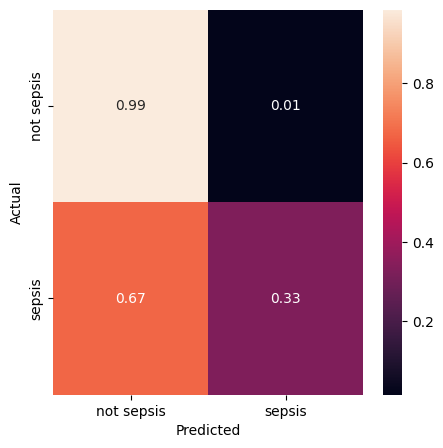

In [93]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [100]:
joblib.dump(forest_model, "./random_forest.joblib")

['./random_forest.joblib']

In [81]:
import os
import psutil

# Function to get the memory usage in GB
def get_memory_usage_in_gb():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info().rss  # Resident Set Size in bytes
    return memory_info / (1024 ** 3)  # Convert to GB

print(f"RAM usage = {get_memory_usage_in_gb():.2f} GB")

RAM usage = 0.03 GB
